In [1510]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import numpy as np
import itertools
from prophet.diagnostics import cross_validation , performance_metrics
from prophet.plot import plot_cross_validation_metric


In [1511]:
data = pd.read_csv("./2_merge_data/TABLE1.csv")

gdp = pd.read_csv("./gdp_monthly.csv")


In [1512]:
gdp

,YearMonth,gdp
0,2017-01-01,3.830606e+06
1,2017-02-01,3.803995e+06
2,2017-03-01,3.779959e+06
3,2017-04-01,3.753348e+06
4,2017-05-01,3.786725e+06
...,...,...
86,2024-03-01,4.550339e+06
87,2024-04-01,4.513599e+06
88,2024-05-01,4.541504e+06
89,2024-06-01,4.570338e+06


In [1513]:
data['YearMonth'] = data['Year'].astype(str) + '-' + data['Publish_month'].astype(int).astype(str)
data.head()

,Eid,Agency_Name,Subject_Field,Publish_month,Year,Country,Title,YearMonth
0,2-s2.0-85053164279,Ratchadapisek Sompoch Endowment Fund,Materials Science,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10
1,2-s2.0-85053164279,Ratchadapisek Sompoch Endowment Fund,Physics and Astronomy,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10
2,2-s2.0-85053164279,Surface Coatings Technology for Metals and Mat...,Materials Science,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10
3,2-s2.0-85053164279,Surface Coatings Technology for Metals and Mat...,Physics and Astronomy,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10
4,2-s2.0-85053164279,NSFC,Materials Science,10.0,2018,China,Effects of iron content on the microstructure ...,2018-10


In [1514]:
data.loc[:, 'YearMonth'] = pd.to_datetime(data['YearMonth'], errors='coerce', format='%Y-%m')
data.head()

,Eid,Agency_Name,Subject_Field,Publish_month,Year,Country,Title,YearMonth
0,2-s2.0-85053164279,Ratchadapisek Sompoch Endowment Fund,Materials Science,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10-01 00:00:00
1,2-s2.0-85053164279,Ratchadapisek Sompoch Endowment Fund,Physics and Astronomy,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10-01 00:00:00
2,2-s2.0-85053164279,Surface Coatings Technology for Metals and Mat...,Materials Science,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10-01 00:00:00
3,2-s2.0-85053164279,Surface Coatings Technology for Metals and Mat...,Physics and Astronomy,10.0,2018,Thailand,Effects of iron content on the microstructure ...,2018-10-01 00:00:00
4,2-s2.0-85053164279,NSFC,Materials Science,10.0,2018,China,Effects of iron content on the microstructure ...,2018-10-01 00:00:00


In [1534]:
data_grouped = data.groupby(['Subject_Field'])['Eid'].count().reset_index()
data_grouped['Subject_Field'].to_list()

['Agricultural and Biological Sciences',
 'Arts and Humanities',
 'Biochemistry, Genetics and Molecular Biology',
 'Business, Management and Accounting',
 'Chemical Engineering',
 'Chemistry',
 'Computer Science',
 'Decision Sciences',
 'Dentistry',
 'Earth and Planetary Sciences',
 'Economics, Econometrics and Finance',
 'Energy',
 'Engineering',
 'Environmental Science',
 'Health Professions',
 'Immunology and Microbiology',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Multidisciplinary',
 'Neuroscience',
 'Nursing',
 'Pharmacology, Toxicology and Pharmaceutics',
 'Physics and Astronomy',
 'Psychology',
 'Social Sciences',
 'Veterinary']

In [1516]:
data_grouped = data.groupby(['YearMonth', 'Subject_Field'])['Eid'].count().reset_index()
data_grouped.head()

,YearMonth,Subject_Field,Eid
0,2017-01-01,Agricultural and Biological Sciences,29
1,2017-01-01,"Biochemistry, Genetics and Molecular Biology",47
2,2017-01-01,"Business, Management and Accounting",4
3,2017-01-01,Chemical Engineering,18
4,2017-01-01,Chemistry,32


In [1517]:
subject_area = 'Business, Management and Accounting'
subject_country_data = data_grouped[(data_grouped['Subject_Field'] == subject_area) ]
subject_country_data.dtypes


YearMonth        datetime64[ns]
Subject_Field            object
Eid                       int64
dtype: object

In [1518]:
gdp['YearMonth'] = pd.to_datetime(gdp['YearMonth'])
subject_country_data = subject_country_data.merge(gdp,on="YearMonth",how="left")

In [1519]:
subject_country_data.loc[:, 'YearMonth'] = pd.to_datetime(subject_country_data['YearMonth'], errors='coerce', format='%Y-%m')
subject_country_data

,YearMonth,Subject_Field,Eid,gdp
0,2017-01-01,"Business, Management and Accounting",4,3.830606e+06
1,2017-02-01,"Business, Management and Accounting",1,3.803995e+06
2,2017-03-01,"Business, Management and Accounting",4,3.779959e+06
3,2017-04-01,"Business, Management and Accounting",5,3.753348e+06
4,2017-07-01,"Business, Management and Accounting",5,3.854593e+06
5,2017-09-01,"Business, Management and Accounting",4,3.986359e+06
6,2017-11-01,"Business, Management and Accounting",5,4.051112e+06
7,2018-01-01,"Business, Management and Accounting",3,4.053070e+06
8,2018-04-01,"Business, Management and Accounting",2,3.999458e+06
9,2018-06-01,"Business, Management and Accounting",3,4.043578e+06


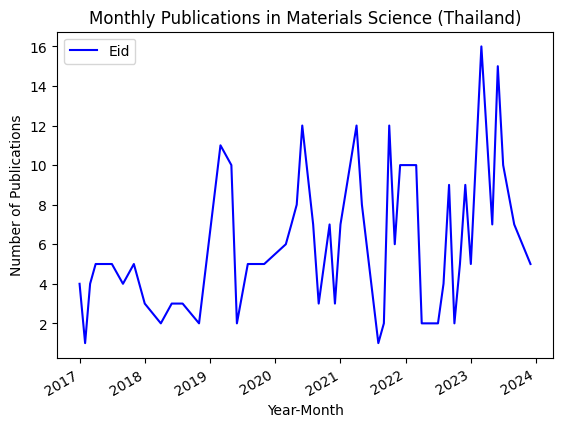

In [1520]:
subject_country_data = subject_country_data.set_index('YearMonth')

subject_country_data.plot(y='Eid', title="Monthly Publications in Materials Science (Thailand)", color='blue')
plt.xlabel('Year-Month')
plt.ylabel('Number of Publications')
plt.show()

In [1521]:
subject_country_data = subject_country_data.asfreq('MS')
Q1_pred = subject_country_data['Eid'].quantile(0.1)
Q3_pred = subject_country_data['Eid'].quantile(0.9)
subject_country_data['Eid'] = subject_country_data['Eid'].apply(lambda x : Q1_pred if x < Q1_pred else (Q3_pred if x > Q3_pred else x))
print(Q1_pred)

# median_y = subject_country_data['Eid'].median()
# mad = np.median(np.abs(subject_country_data['Eid'] - median_y))
# threshold = 3 * mad  # or some other factor
# subject_country_data['Eid'] = np.where(np.abs(subject_country_data['Eid'] - median_y) > threshold, median_y, subject_country_data['Eid'])



2.0


In [1522]:
df = subject_country_data.reset_index()  # Reset index to access 'YearMonth' as a column

# Rename columns to Prophet's expected format
df_prophet = df.rename(columns={'YearMonth': 'ds', 'Eid': 'y'})
df_prophet


,ds,Subject_Field,y,gdp
0,2017-01-01,"Business, Management and Accounting",4.0,3.830606e+06
1,2017-02-01,"Business, Management and Accounting",2.0,3.803995e+06
2,2017-03-01,"Business, Management and Accounting",4.0,3.779959e+06
3,2017-04-01,"Business, Management and Accounting",5.0,3.753348e+06
4,2017-05-01,NaN,NaN,NaN
...,...,...,...,...
79,2023-08-01,NaN,NaN,NaN
80,2023-09-01,"Business, Management and Accounting",7.0,4.569231e+06
81,2023-10-01,NaN,NaN,NaN
82,2023-11-01,NaN,NaN,NaN


In [1523]:


train = df_prophet.iloc[:-4]  # Use all but last 12 months as training
# test = df_prophet.iloc[-12:]  # Use the last 12 months as the test set
# model = Prophet()
# model.fit(train)
# future = test[['ds']] 
# forecast = model.predict(future)
# comparison = test[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds', how='left')
# comparison

# if comparison['yhat'].isna().any():
#     print("Warning: 'yhat' contains NaN values. The graph might not render as expected.")

# # Plot the actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(comparison['ds'], comparison['y'], label='Actual (y)', color='blue', marker='o')
# plt.plot(comparison['ds'], comparison['yhat'], label='Predicted (yhat)', color='orange', linestyle='--', marker='x')

# # Add labels, legend, and title
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.grid(True)

# # Rotate x-axis labels if needed
# plt.xticks(rotation=45)

# # Show the plot
# plt.tight_layout()
# plt.show()


# mae = mean_absolute_error(comparison['y'], comparison['yhat'])
# rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
# mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")




# future = model.make_future_dataframe(periods=12, freq='M')  # Extend for 12 months
# forecast = model.predict(future)
# forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test['ds'].values]

# # Combine the predicted and actual values for comparison
# combined = test.set_index('ds').join(forecast_test, how='left')
# combined.rename(columns={'y': 'actual', 'yhat': 'predicted'}, inplace=True)
# print(combined)

In [1524]:

model = Prophet(changepoint_prior_scale= 0.5, seasonality_prior_scale= 1.0, n_changepoints= 10)
model.add_regressor('gdp')
model.fit(train)
future = model.make_future_dataframe(periods=11, freq='MS')
future = future.merge(gdp, how='left', left_on='ds', right_on='YearMonth')
future = future.drop(columns="YearMonth")

# df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
# forecast['ds'] = pd.to_datetime(forecast['ds'])
# forecast = forecast.drop(columns=['multiplicative_terms', 'multiplicative_terms_lower','multiplicative_terms_upper'])
# comparison = forecast.merge(df_prophet[['ds', 'y']], on='ds', how='left')
# print(comparison.head())

# graph = model.plot(forecast)
# print("Unique dates in test:", test['ds'].sort_values().unique())
# print("Unique dates in forecast:", forecast['ds'].sort_values().unique())
# comparison.to_csv('.csv', index=False)

15:30:32 - cmdstanpy - INFO - Chain [1] start processing


15:30:32 - cmdstanpy - INFO - Chain [1] done processing


In [1525]:
forecast = model.predict(future)

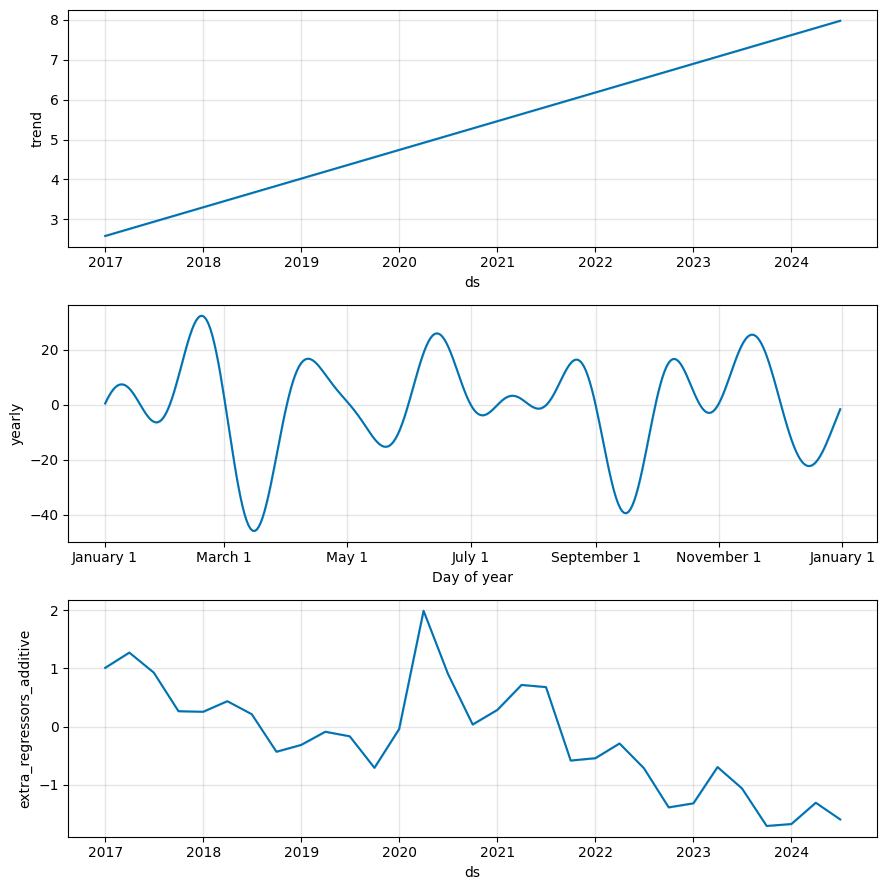

In [1526]:
graph = model.plot_components(forecast)

Text(89.34722222222221, 0.5, 'Articles')

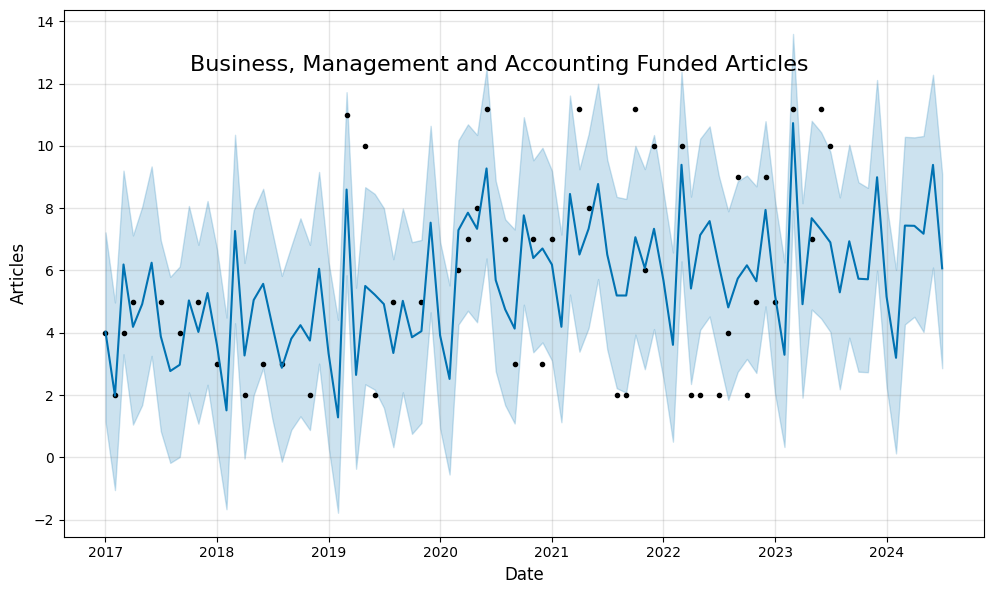

In [1527]:
graph = model.plot(forecast)

graph.suptitle(subject_area + " Funded Articles", fontsize=16 ,y = 0.9) 

# plt.subplots_adjust(top=0.95) 

ax = graph.gca()  
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Articles", fontsize=12)


In [1528]:
df_cv = cross_validation(model, initial='1920 days', period='180 days', horizon='365 days')


  0%|          | 0/1 [00:00<?, ?it/s]15:30:33 - cmdstanpy - INFO - Chain [1] start processing
15:30:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


In [1529]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-08-01,2.781752,0.257294,5.226883,4.0,2022-07-01
1,2022-09-01,1.970837,-0.507699,4.486527,9.0,2022-07-01
2,2022-10-01,9.808402,7.351355,12.053674,2.0,2022-07-01
3,2022-11-01,3.164108,0.832613,5.779480,5.0,2022-07-01
4,2022-12-01,5.376416,3.073072,7.929820,9.0,2022-07-01
5,2023-01-01,1.877562,-0.647547,4.292980,5.0,2022-07-01
6,2023-03-01,8.313788,5.816827,10.866022,11.2,2022-07-01
7,2023-05-01,5.636055,3.145421,7.905419,7.0,2022-07-01
8,2023-06-01,1.597260,-0.975856,4.179877,11.2,2022-07-01
9,2023-07-01,2.474880,0.095059,4.931886,10.0,2022-07-01


In [1530]:
df_p = performance_metrics(df_cv)
print(df_p)

   horizon        mse      rmse       mae      mape     mdape     smape  \
0  31 days   1.484127  1.218248  1.218248  0.304562  0.304562  0.359272   
1  62 days  49.409127  7.029163  7.029163  0.781018  0.781018  1.281427   
2  92 days  60.971141  7.808402  7.808402  3.904201  3.904201  1.322516   
3 123 days   3.370499  1.835892  1.835892  0.367178  0.367178  0.449747   
4 153 days  13.130360  3.623584  3.623584  0.402620  0.402620  0.504101   
5 184 days   9.749621  3.122438  3.122438  0.624488  0.624488  0.908007   
6 243 days   8.330217  2.886212  2.886212  0.257697  0.257697  0.295813   
7 304 days   1.860347  1.363945  1.363945  0.194849  0.194849  0.215882   
8 335 days  92.212611  9.602740  9.602740  0.857387  0.857387  1.500749   
9 365 days  56.627424  7.525120  7.525120  0.752512  0.752512  1.206444   

   coverage  
0       1.0  
1       0.0  
2       0.0  
3       1.0  
4       0.0  
5       0.0  
6       0.0  
7       1.0  
8       0.0  
9       0.0  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


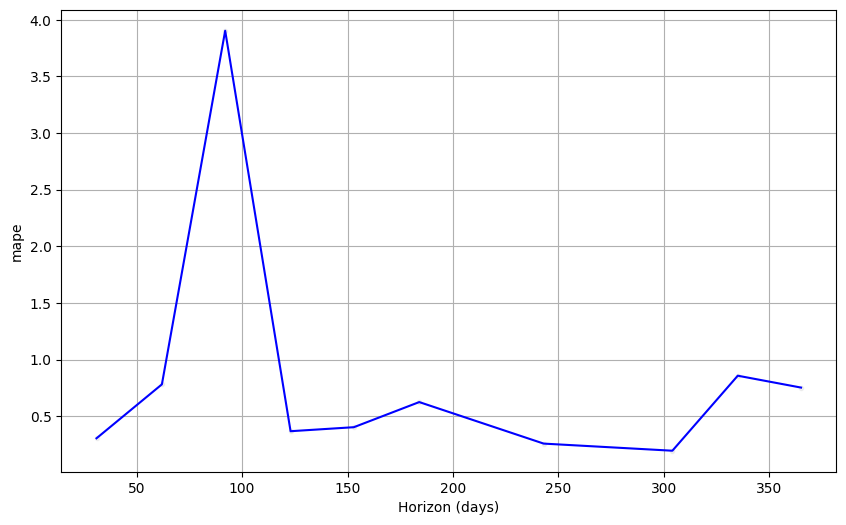

In [1531]:
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [1532]:


# param_grid = {  
#   'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
#   'seasonality_prior_scale': [1.0, 5.0, 10.0],
#   'n_changepoints': [5, 10, 25]
# }

# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# results = []
# for params in all_params:
#     model = Prophet(**params)
#     model.fit(train)
#     df_cv = cross_validation(model, initial='1920 days', horizon='180 days', period='365 days')
#     df_p = performance_metrics(df_cv)
#     results.append((params, df_p['rmse'].values[0]))

# # Sort and pick the best
# best_params = sorted(results, key=lambda x: x[1])[0]



In [1533]:
# print(best_params)